# First Objective: "Grotrian diagram visualisation"

This is my solution to the first objective of the "Grotrian diagram visualisation".
[GSoC'23 ideas page](https://tardis-sn.github.io/gsoc_2023/ideas/)

In [1]:
# Download the atomic data
from tardis.io.atom_data.util import download_atom_data
download_atom_data('kurucz_cd23_chianti_H_He')


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [ ]:
# Run simulation
from tardis import run_tardis
sim = run_tardis('tardis_example.yml', virtual_packet_logging=True, log_level='CRITICAL')

# Si ion density vs velocity

In [3]:
# Define Si constants
SI_ATOMIC_NUMBER = 14
SI_SYMBOL = 'Si'

In [4]:
# Extract ion densities
si_ion_densities = {}
si_ion_densities[0] = sim.plasma.ion_number_density.loc[SI_ATOMIC_NUMBER, 0]
si_ion_densities[1] = sim.plasma.ion_number_density.loc[SI_ATOMIC_NUMBER, 1]

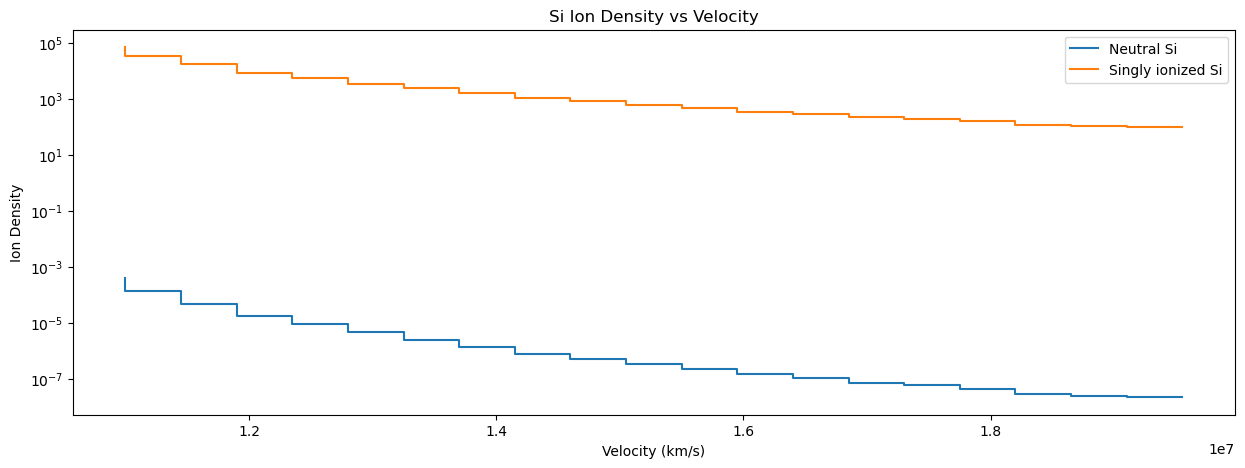

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

inner_velocities = sim.model.v_inner.si

plt.yscale("log")

plt.step(inner_velocities, si_ion_densities[0], label='Neutral Si')
plt.step(inner_velocities, si_ion_densities[1], label='Singly ionized Si')

plt.title('Si Ion Density vs Velocity')
plt.xlabel('Velocity (km/s)')
plt.ylabel('Ion Density')

_ = plt.legend()